Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]
2. Sudden flares of active galactic nuclei
3. Supernovae

**Tasks**

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**

1. Read in solutions/transient.npy. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2. One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as: 

    $y = b$, for $t < t_0$ 

    $y = b + A \exp{[-\alpha (t - t_0)]}$, for $t \geq t_0$ 

    where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

    Code this burst model, and code a likelihood function for this data with the burst model. 

    Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.

3. Using one of the MCMC sampler that we looked at in class (emcee, pymc), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of ${b, \ A, \ t_0, \ \alpha}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b \in Uniform[0, 50]$, $A \in Uniform[0, 50]$, $t_0 \in Uniform[0, 100]$, and $ln(\alpha) \in Uniform[-5, 5]$ (careful: uniform in $ln(\alpha)$, not $\alpha$).

4. Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5. Make a corner plot of the 4-D parameter space, with labels, $[68, 95] %$ credible levels and quantiles, and titles.

6. Now choose 100 samples randomly from your burned, thinned chain and plot the 100 corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these 100 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7. For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0 = X_{-Z}^{+Y}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization.hist
import astroML.stats as astroMLstats
import emcee
import corner

from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import uniform
from IPython.display import display, Latex

In [2]:
def model(t, b, A, alpha, t_0):
    return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
    
def log_prior(params, bounds):
    b, A, ln_alpha, t_0 = params
    if (bounds[0][0] < b < bounds[0][1] and
        bounds[1][0] < A < bounds[1][1] and
        bounds[2][0] < ln_alpha < bounds[2][1] and
        bounds[3][0] < t_0 < bounds[3][1]):
        return 0.0  # log(1)
    return -np.inf

def log_likelihood(params, t, data, err):
    b, A, ln_alpha, t_0 = params
    alpha = np.exp(ln_alpha)
    model_flux = model(t, b, A, alpha, t_0)
    return -0.5 * np.sum(((data - model_flux) / err)**2 + np.log(2 * np.pi * err**2))

def log_posterior(params, t, data, err, bounds):
    lp = log_prior(params, bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, data, err)

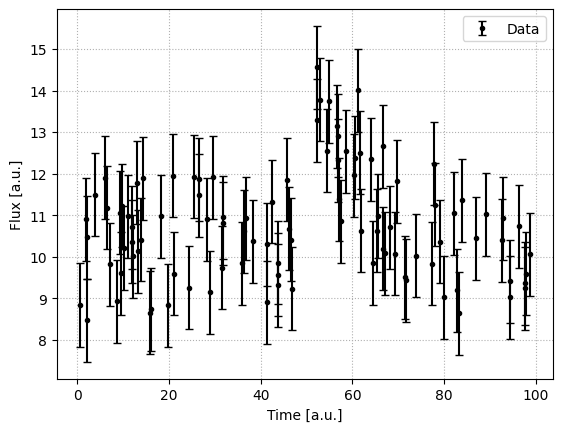

In [3]:
# Import data
path = '/home/alessia_pozzi/Astrostatistic/11_12_Bayesian/transient.npy'
data = np.load(path)

t = data[:, 0]
flux = data[:, 1]
err_flux = data[:, 2]

# Plot data
plt.errorbar(t, flux, err_flux, fmt='.', color='black', capsize=3, label = 'Data')
#plt.title()
plt.xlabel('Time [a.u.]')
plt.ylabel('Flux [a.u.]')
plt.legend()
plt.grid(linestyle=':')
plt.show()

In [ ]:
# Limits of parameters distribution
# N.B.: The order of the parameter is: b, A, ln(alpha), t_0
bounds = [[0, 50], [0, 50], [-5, 5], [0, 100]]

ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
burn = 10000  # 'burn-in' period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take **for each walker**

np.random.seed(0)

# Starting guess for each parameter
starting_guesses = np.array([
    np.random.uniform(bounds[0][0], bounds[0][1], nwalkers),       # b
    np.random.uniform(bounds[1][0], bounds[1][1], nwalkers),       # A
    np.random.uniform(bounds[2][0], bounds[2][1], nwalkers),       # ln(alpha)
    np.random.uniform(bounds[3][0], bounds[3][1], nwalkers),       # t_0
]).T

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, flux, err_flux, bounds))
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

# Obtswin the complete chain
chain = sampler.get_chain()  # shape: (nsteps, nwalkers, ndim)

# Autocorrelation time
tau = sampler.get_autocorr_time()
print(tau)
thin = int(np.max(tau)) + 1

# Remove the autocorreleted samples
samples = sampler.get_chain(discard=burn, thin=thin, flat=True)

print(f'Original chain: {sampler.chain.shape}')
print(f'Burn-in: {burn}, Thin: {thin}')
print(f'Shape after thinning: {samples.shape}')

/tmp/ipykernel_1282/307378680.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
  0%|          | 0/100000 [00:00<?, ?it/s]/tmp/ipykernel_1282/307378680.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
100%|██████████| 100000/100000 [00:54<00:00, 1834.67it/s]


[147.14959134 633.98410488 794.98745127 803.38099288]
Original chain: (10, 100000, 4)
Burn-in: 10000, Thin: 804
Shape after thinning: (1110, 4)


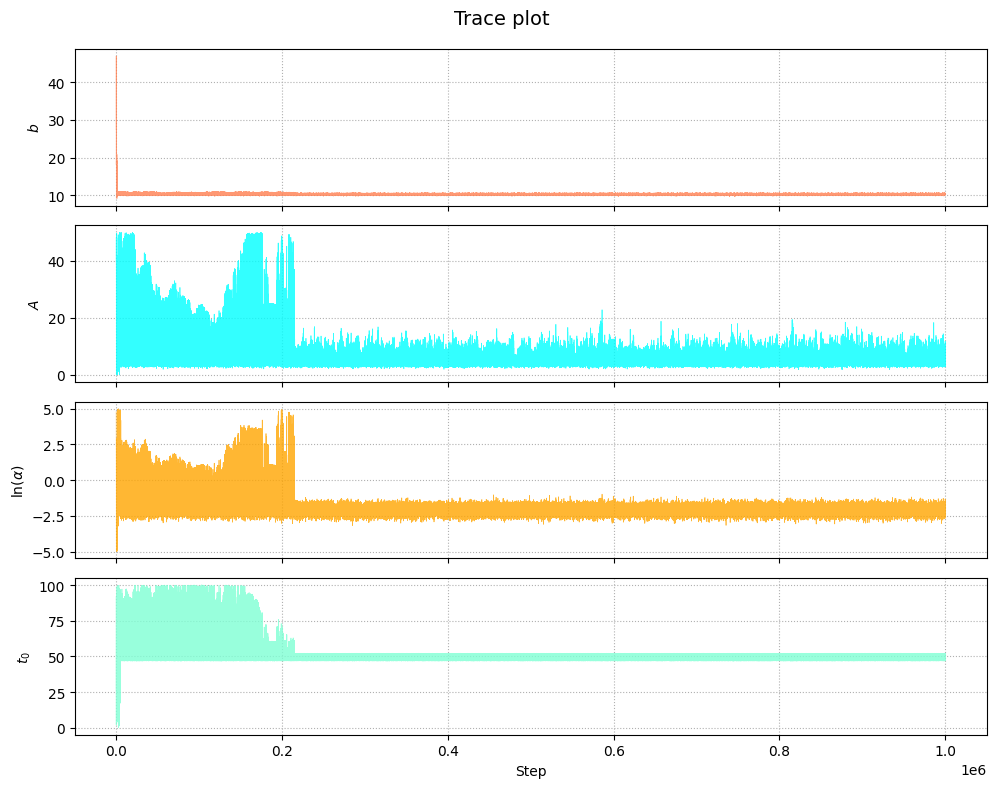

In [5]:
# Trace plot
labels = [r'$b$', r'$A$', r'$\ln(\alpha)$', r'$t_0$']

colors = ['coral', 'cyan', 'orange', 'aquamarine']

flat_chain = chain.reshape(-1, ndim) # (nsteps, nwalkers) -> (nsteps * nwalkers)

fig, axes = plt.subplots(ndim, figsize=(10, 8), sharex=True)

for i in range(ndim):
    axes[i].plot(flat_chain[:, i], color=colors[i], alpha=0.8, lw=0.5)
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True, linestyle=':')

axes[-1].set_xlabel("Step")
fig.suptitle("Trace plot", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


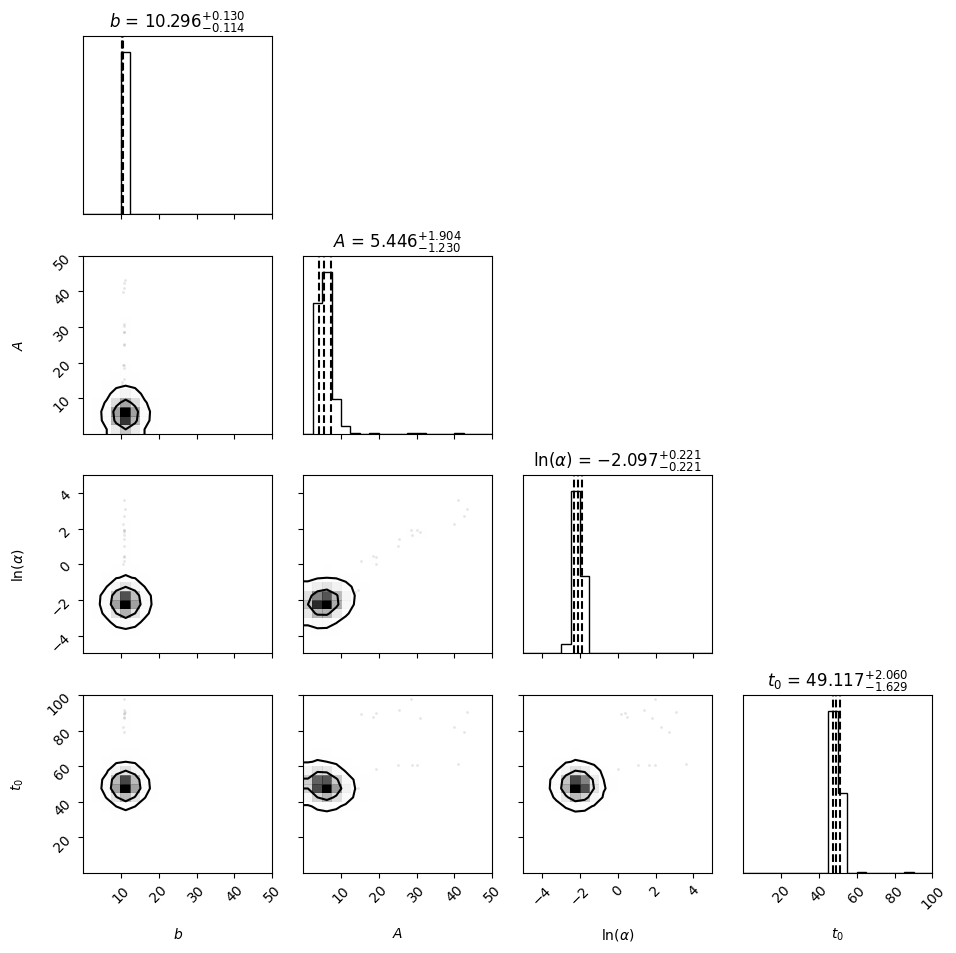

In [6]:
# Corner Plot
labels = [r'$b$', r'$A$', r'$\ln(\alpha)$', r'$t_0$']

fig = corner.corner(samples, labels=labels, 
                    range=bounds,
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_fmt='.3f', 
                    title_kwargs={'fontsize': 12}, 
                    levels=(0.68, 0.95), 
                    smooth=1.0)

fig.tight_layout()

There is a strong correlation between $t_0$ and A. The model fit well both if $t_0$ is small and A is bigger, and if $t_0$ is big and A is smaller

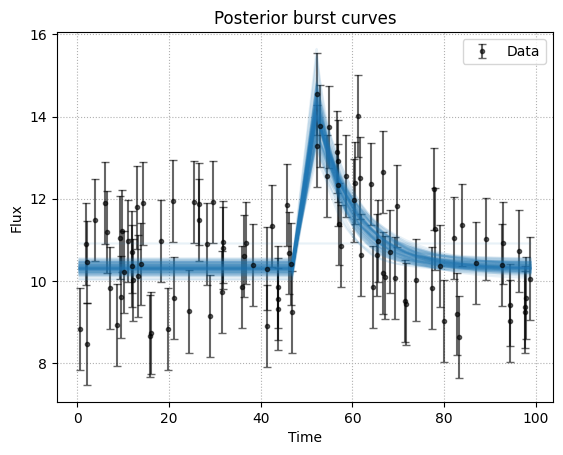

In [7]:
# Extract 100 random samples
posterior_samples = samples[np.random.choice(samples.shape[0], 100, replace=False)]

# Plot the data
plt.errorbar(t, flux, yerr=err_flux, fmt='.', color = 'k', capsize=3, label='Data', alpha=0.6)

# Plot the posterior for the sampled parameters
for b, A, ln_alpha, t_0 in posterior_samples:
    alpha = np.exp(ln_alpha)
    plt.plot(t, model(t, b, A, alpha, t_0), color='C0', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Posterior burst curves')
plt.legend()
plt.grid(linestyle=':')
plt.show()

In [8]:
# Parameter values and errors estimation
percentiles_90 = [16, 84]
params = ['b', 'A', r'ln(\alpha)', 't_0']

latex_output = r'\begin{array}{l}'

for i, param in enumerate(params):
    param_samples = samples[:, i]
    median = np.median(param_samples)
    lower, upper = np.percentile(param_samples, percentiles_90)

    latex_output += f'{param} &= {median:.3f}_{{-{median-lower:.3f}}}^{{+{upper-median:.3f}}} && \\\\'

latex_output += r'\end{array}'

display(Latex(latex_output))

<IPython.core.display.Latex object>

**Part 2**

8. Fit the same model from before with the same priors, but this time use nested sampling. 

    $ y = b$, for $t < t_0$

    $y = b + A \exp[-\alpha (t - t_0)]$, for $t \geq t_0$ 

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used ppf from scipy.stats.uniform, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

9. Another possible model that may explain the data is a Gaussian profile described by:
    $y = b + A \exp[-\alpha (t - t_0)^2 / (2 \sigma_W^2)]$

    Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

10. Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [9]:
import dynesty

from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [ ]:
def prior_trasform(params):
    b, A, ln_alpha, t_0 = params 
    b = 50 * params[0]
    A = 50 * params[1]
    ln_alpha = 10 * params[2] - 5
    t_0 = 100 * params[3]
    return [b, A, ln_alpha, t_0]

def log_likelihood(params):
    b, A, ln_alpha, t_0 = params
    alpha = np.exp(ln_alpha)
    model_flux = model(t, b, A, alpha, t_0)
    return -0.5 * np.sum(((flux - model_flux) / err_flux)**2 + np.log(2 * np.pi * err_flux**2))

# Gaussian model
def model_gauss(t, b, A, alpha, t0, sigma_w):
    return b + A * np.exp(-alpha * (t - t0)**2 / (2 * sigma_w**2))

def log_likelihood_gauss(theta):
    b, A, ln_alpha, t0, ln_sigma_w = theta
    alpha = np.exp(ln_alpha)
    sigma_w = np.exp(ln_sigma_w)
    model_vals = model_gauss(t, b, A, alpha, t0, sigma_w)
    chi2 = np.sum(((flux - model_vals) / err_flux)**2)
    return -0.5 * chi2

def prior_transform_gauss(u):
    b = uniform(0, 50).ppf(u[0])
    A = uniform(0, 50).ppf(u[1])
    ln_alpha = uniform(-5, 10).ppf(u[2])          # ln(alpha) ∈ [-5, 5]
    t0 = uniform(0, 100).ppf(u[3])
    ln_sigma_w = uniform(-3, 6).ppf(u[4])         # ln(sigma_w) ∈ [-3, 3]
    return [b, A, ln_alpha, t0, ln_sigma_w]



In [11]:
sampler = dynesty.NestedSampler(log_likelihood, prior_trasform, ndim)
sampler.run_nested()
sresults = sampler.results

/tmp/ipykernel_1282/307378680.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/tmp/ipykernel_1282/307378680.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
1509it [00:15, 58.63it/s, bound: 0 | nc: 29 | ncall: 9265 | eff(%): 16.287 | loglstar:   -inf < -433.835 <    inf | logz: -442.167 +/-  0.123 | dlogz: 281.523 >  0.509]      /tmp/ipykernel_1282/307378680.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/tmp/ipykernel_1282/307378680.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/tmp/ipykernel_1282/307378680.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
/tmp/ipykernel_1282/307378680.py:2: RuntimeWarning: overflow encountered in multiply
 

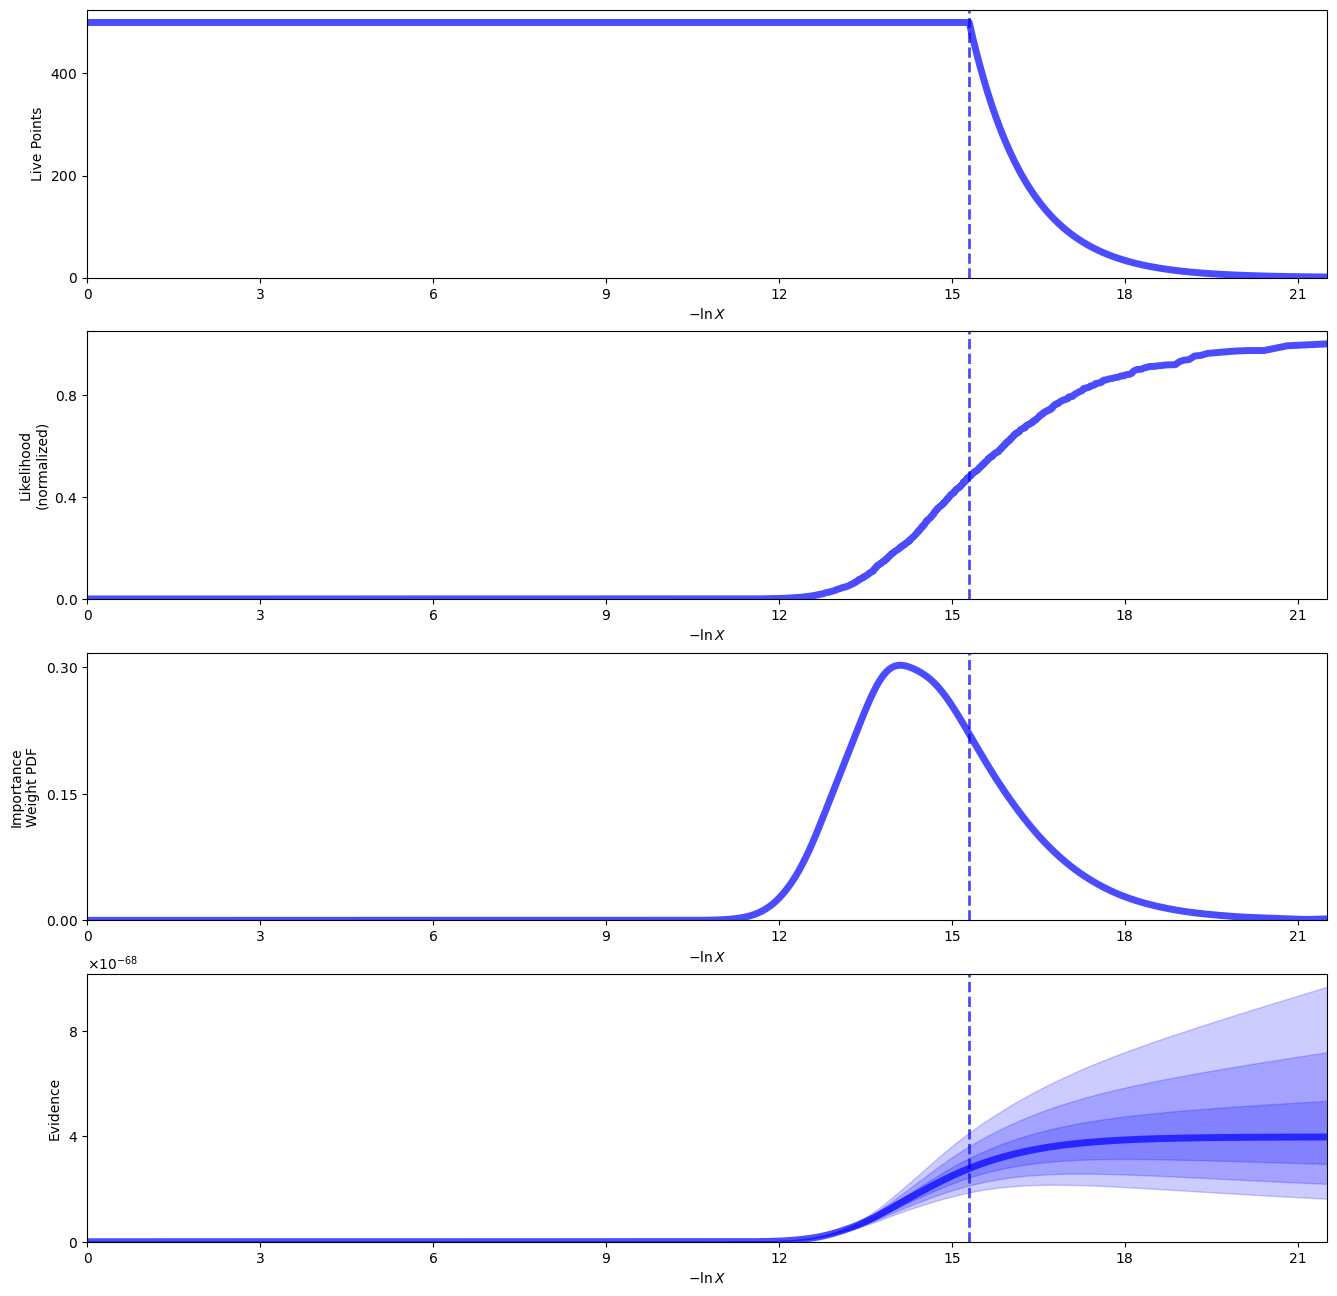

In [28]:
rfig, raxes = dyplot.runplot(sresults)

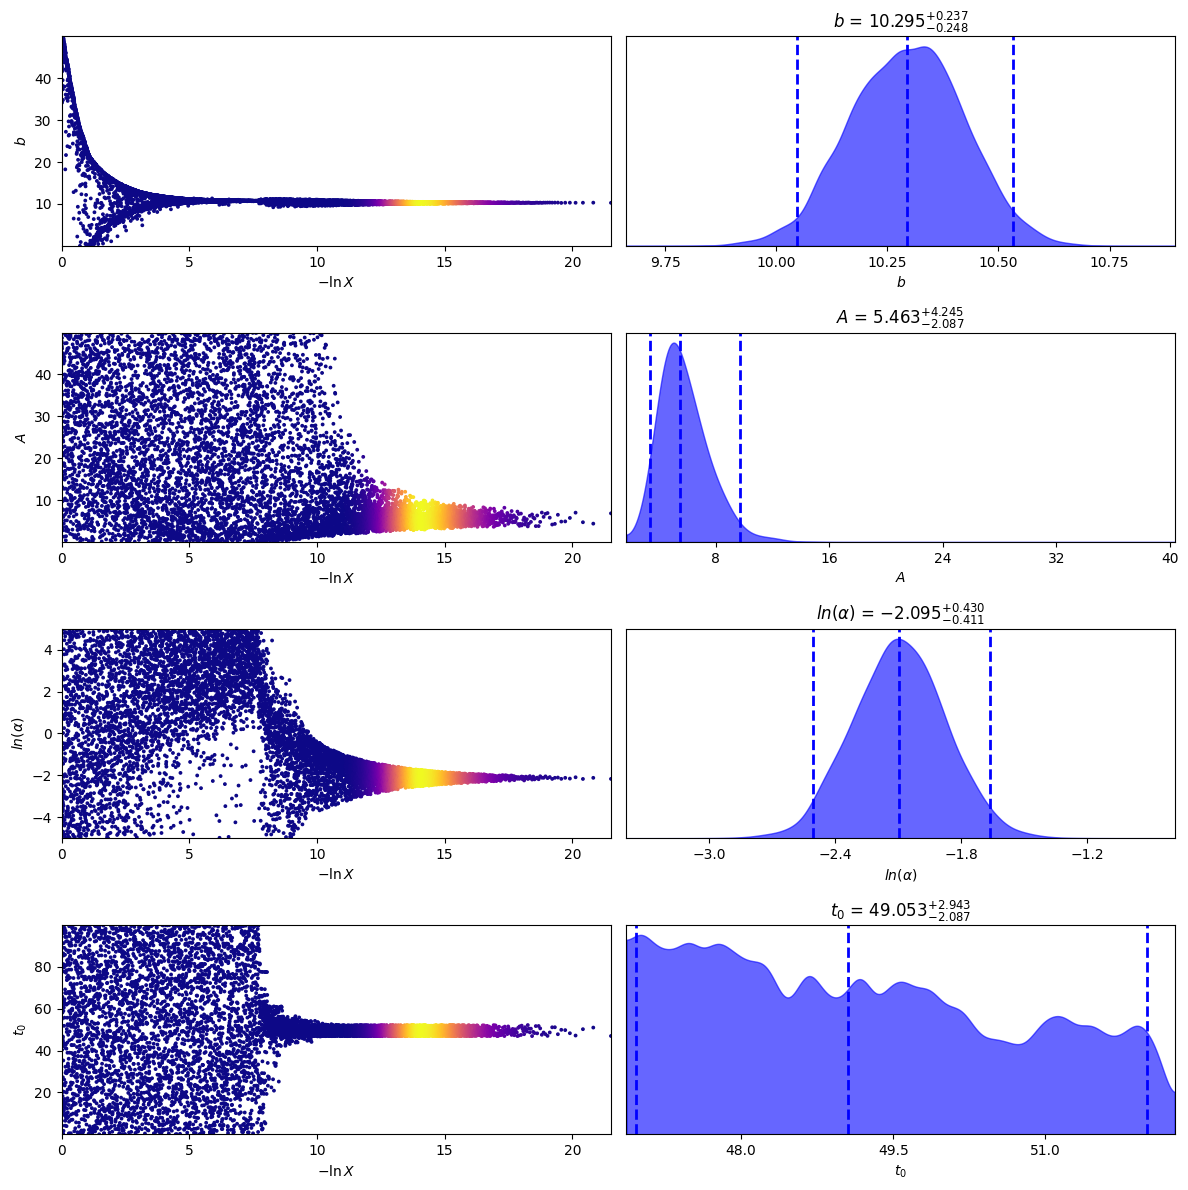

In [31]:
# Trace plot
labels = [r'$b$', r'$A$', r'$ln(\alpha)$', r'$t_0$']

tfig, taxes = dyplot.traceplot(sresults,
                               labels=labels,
                               show_titles=True, 
                               title_fmt='.3f', 
                               title_kwargs={'fontsize': 12})

tfig.tight_layout()

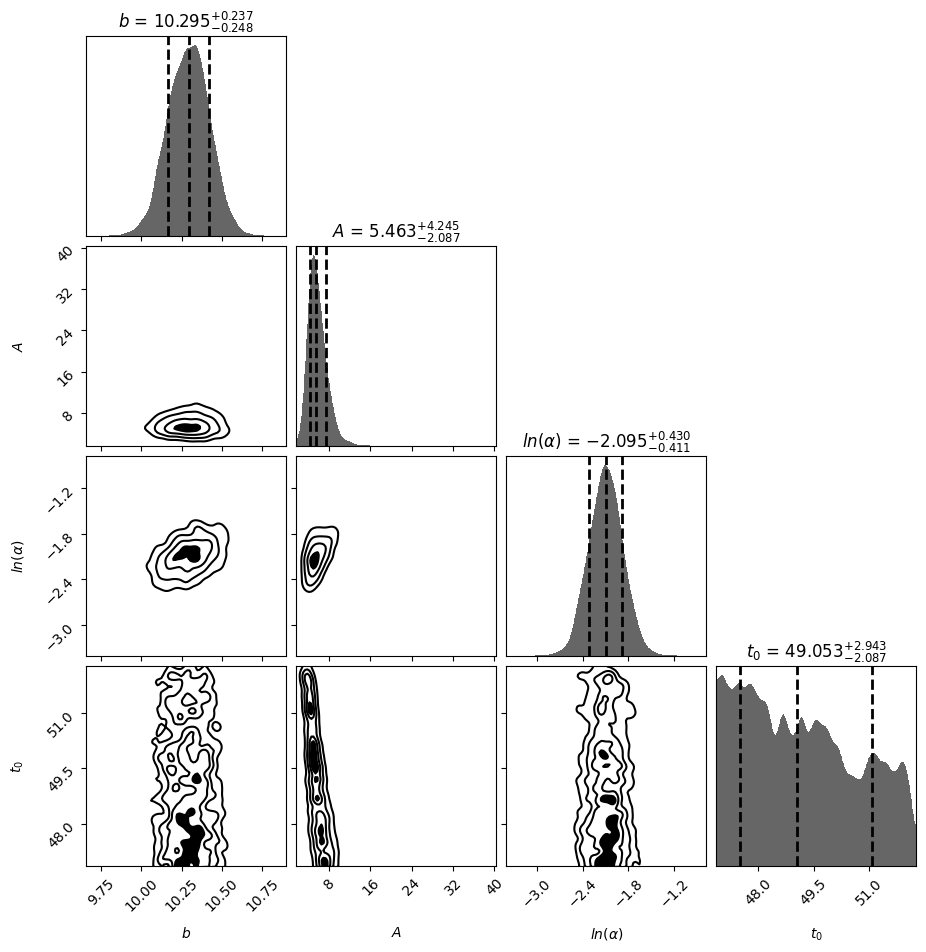

In [21]:
# Corner plot
labels = [r'$b$', r'$A$', r'$ln(\alpha)$', r'$t_0$']

fig = dyplot.cornerplot(sresults, labels=labels, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_fmt='.3f', 
                    title_kwargs={'fontsize': 12})

In [18]:
# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: \n' + str(mean) + '\n' + str(cov))


Bayesian evidence 3.976336084196623e-68
68% parameter credible regions are:
 [[10.167209473540032, 10.418426301106512], [4.274863502934889, 7.353553433429289], [-2.311503690148967, -1.8784149657672036], [47.497873602888404, 51.073866392240724]]

Mean and covariance of parameters are: 
[10.29386101  5.7771712  -2.09457949 49.18541165]
[[ 1.58438983e-02  1.47768007e-02  1.12119603e-02 -2.15701017e-03]
 [ 1.47768007e-02  2.84118046e+00  2.11291008e-01 -1.72902249e+00]
 [ 1.12119603e-02  2.11291008e-01  4.77971487e-02 -1.13960663e-02]
 [-2.15701017e-03 -1.72902249e+00 -1.13960663e-02  2.32339844e+00]]


In [ ]:
# Nested sampling run
ndim_gauss = 5
sampler_gauss = dynesty.NestedSampler(
    log_likelihood_gauss,
    prior_transform_gauss,
    ndim=ndim_gauss,
    sample='rwalk',
    bootstrap=0
)
sampler_gauss.run_nested()
sresults_gauss = sampler_gauss.results


8579it [13:14, 10.80it/s, +500 | bound: 93 | nc: 1 | ncall: 187306 | eff(%):  4.860 | loglstar:   -inf < -52.462 <    inf | logz: -68.891 +/-  0.181 | dlogz:  0.001 >  0.509]


In [35]:
# Confronto delle evidenze logaritmiche
logZ_burst = sresults.logz[-1]
logZ_gauss = sresults_gauss.logz[-1]
delta_logZ = logZ_burst - logZ_gauss

print(f"logZ burst   = {logZ_burst:.2f}")
print(f"logZ gaussian = {logZ_gauss:.2f}")
print(f"Δ logZ (burst - gauss) = {delta_logZ:.2f}")

# Jeffreys scale interpretation
if abs(delta_logZ) < 1:
    evidence = "Inconclusive"
elif abs(delta_logZ) < 2.5:
    evidence = "Weak"
elif abs(delta_logZ) < 5:
    evidence = "Moderate"
else:
    evidence = "Strong"

favored = "burst" if delta_logZ > 0 else "gaussian"
print(f"{evidence} evidence in favor of the {favored} model.")


logZ burst   = -155.20
logZ gaussian = -68.89
Δ logZ (burst - gauss) = -86.30
Strong evidence in favor of the gaussian model.


In [36]:
# Stima parametri gaussiani (come già fatto per il burst)
posterior_gauss = sresults_gauss.samples  # shape: (N_samples, 5)
param_names = ['b', 'A', r'\ln(\alpha)', 't_0', r'\ln(\sigma_w)']
percentiles_90 = [5, 95]

latex_output = r'\begin{array}{l}'

for i, name in enumerate(param_names):
    param_samples = posterior_gauss[:, i]
    median = np.median(param_samples)
    lower, upper = np.percentile(param_samples, percentiles_90)
    latex_output += f'{name} &= {median:.3f}_{{-{median - lower:.3f}}}^{{+{upper - median:.3f}}} && \\\\'

latex_output += r'\end{array}'

display(Latex(latex_output))


<IPython.core.display.Latex object>

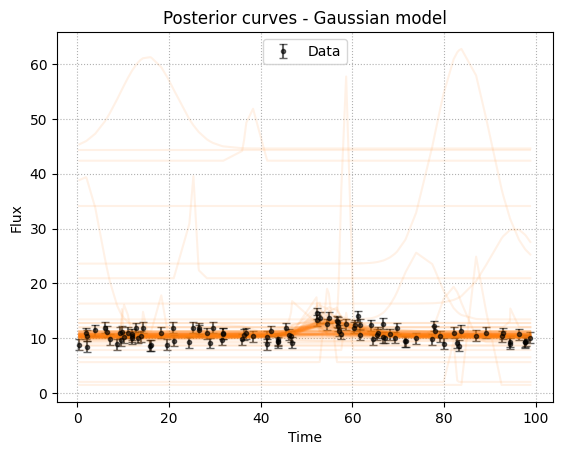

In [50]:
# Selezione 100 campioni casuali
posterior_samples_gauss = posterior_gauss[np.random.choice(posterior_gauss.shape[0], 100, replace=False)]

# Plot dati originali
plt.errorbar(t, flux, yerr=err_flux, fmt='.', color='k', capsize=3, label='Data', alpha=0.6)

# Curve modellate gaussiane
for b, A, ln_alpha, t0, ln_sigma_w in posterior_samples_gauss:
    alpha = np.exp(ln_alpha)
    sigma_w = np.exp(ln_sigma_w)
    plt.plot(t, model_gauss(t, b, A, alpha, t0, sigma_w), color='C1', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Posterior curves - Gaussian model')
plt.grid(linestyle=':')
plt.legend()
plt.show()


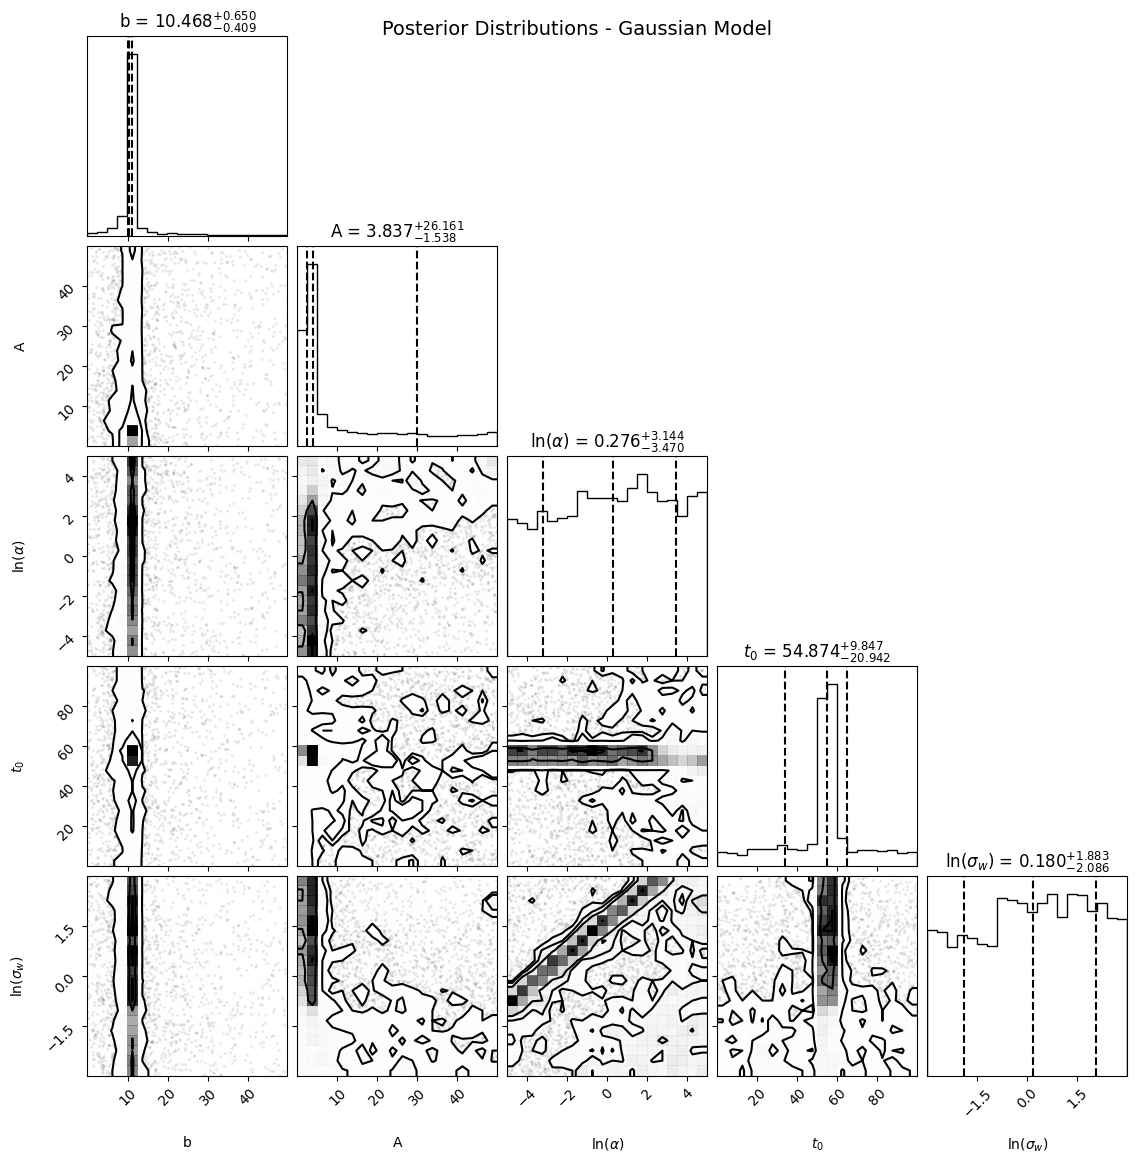

In [ ]:
labels = ['b', 'A', r'$\ln(\alpha)$', r'$t_0$', r'$\ln(\sigma_w)$']

fig = corner.corner(posterior_gauss, labels=labels,
                    #range=,
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_fmt='.3f',
                    title_kwargs={"fontsize": 12})
plt.suptitle("Posterior Distributions - Gaussian Model", fontsize=14)
plt.show()
